# ECE236A (Fall 2025)

This notebook shows **how to use** the provided `utils.py` and your `MySolution_{group_number}.py` for:
- **Task 1** (baseline classifier),
- **Task 2** (centralized compression),
- **Task 3.1** (per-sensor budget), **Task 3.2** (total budget), and
- **Task 3.3** (minimal bits for target accuracy).

It includes **commented-out** code blocks that you can enable after you implement your methods.
For now, we also include **mock results** to show the required plotting formats.

> **Important:** These cells are **guidelines**, not a complete solution. You may (and often should) adapt the code to:
> - output all required artifacts for the report (e.g., chosen allocations, validation choices, baselines),
> - plot additional figures that strengthen your analysis,
> - add helper functions/visualizations to support your arguments.
>
> This boilerplate demonstrates how to **wire up** the methods and plotting utilities. You’re responsible for producing all figures/results requested in the project handout.

In [2]:
from utils import *
from MySolution import MyDecentralized, MyFeatureCompression, MyTargetAllocator # change MySolution to MySolution_{group_number}

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load datasets

Synthetic shapes: (800, 2) (800,)


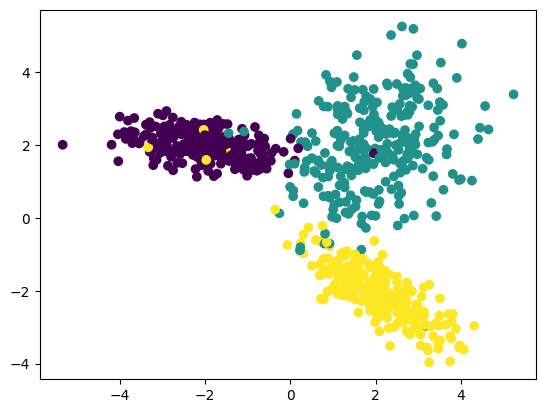

In [3]:
syn_data = prepare_synthetic_data()
print("Synthetic shapes:", syn_data['trainX'].shape, syn_data['trainY'].shape)
plt.scatter(syn_data['trainX'][:, 0], syn_data['trainX'][:, 1], c=syn_data['trainY']); plt.show()

MNIST shapes: (800, 784) (800,)


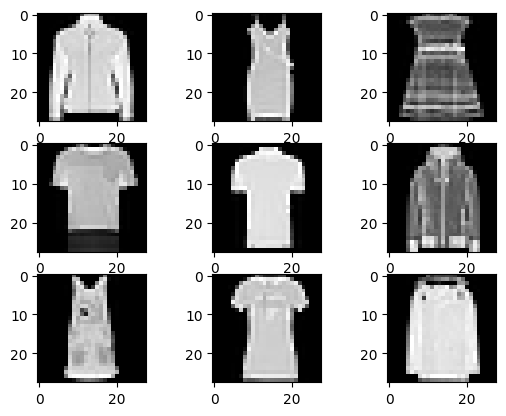

In [4]:
mnist_data = prepare_mnist_data()
print("MNIST shapes:", mnist_data['trainX'].shape, mnist_data['trainY'].shape)
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(mnist_data['trainX'][i].reshape(28,28), cmap='gray')
plt.show()

## Task 1 — Baseline classifier (Decentralized class, no compression)
Uncomment the following once you've implemented `MyDecentralized.train/predict/score`.

In [5]:
clf = MyDecentralized(K=3)
clf.train(syn_data['trainX'], syn_data['trainY'])  # if you need val, modify signature accordingly
task1_test_acc = clf.evaluate(syn_data['testX'], syn_data['testY'])
print("Task 1 test accuracy:", task1_test_acc)

Task 1 test accuracy: 0.972


In [6]:
clf = MyDecentralized(K=3)
clf.train(mnist_data['trainX'], mnist_data['trainY'])  # if you need val, modify signature accordingly
task1_test_acc = clf.evaluate(mnist_data['testX'], mnist_data['testY'])
print("Task 1 test accuracy:", task1_test_acc)

Task 1 test accuracy: 0.898


### Notes on bit budgets

- **Uniform Scalar Quantization (USQ):**  
  The simplest baseline scheme is to quantize each feature (e.g., image pixel) independently using the same number of bits `b`.  
  The total budget is then `B_tot = M * b` with `M = 784` (28×28).  
  Example: `B_TOT_LIST = [784, 1568, 2352]` corresponds to **1 / 2 / 3 bits per feature** under USQ.  
  However, you can assign different bit-depths to different features, which would allow you to reach even lower budgets (e.g., `b=0` for some features).

- **Other quantizers:**  
  If you use non-uniform scalar, companded, or vector quantization, this direct formula may not apply.  
  In those cases, interpret `B_tot` as your **total bits per image** based on your quantizer design  
  (e.g., sum of bits for transmitted indices, parameters, or blocks).  
  - **If you transmit selectively (e.g., only send clustered or informative samples):**  
  Report your budget as the **average total bits per image across the full dataset**,  
  not just the bits for transmitted samples. This ensures fair comparison with methods  
  that send every image.

  Be explicit in your report about how you compute and compare bit budgets.

- **Decentralized setting:**  
  Each sensor has `d_s = 196` features; a per-sensor budget `k` corresponds to a local bit constraint.  
  In USQ, this implies a local bit-depth `b_s ≈ floor(k / d_s)`;  
  in more general designs, `k` is simply the total bits that sensor `s` is allowed to send per image.

- **No-quantization reference:**  
  Original (uncompressed) features are the upper bound.  
  For an 8-bit scalar baseline: `784 * 8 = 6272` bits/image.

- **Compare apples-to-apples:**  
  Use the same total budgets (`B_TOT_LIST`) across centralized and decentralized experiments,  
  but remember that the mapping between bits and quantization precision may differ depending on your quantizer.

## Task 2 — Centralized compression
Uncomment the following once you've implemented `MyFeatureCompression.run_centralized`.

{'B_tot': [4, 8, 20, 40, 80, 160], 'test_accuracy': [0.668, 0.694, 0.762, 0.82, 0.83, 0.872]}


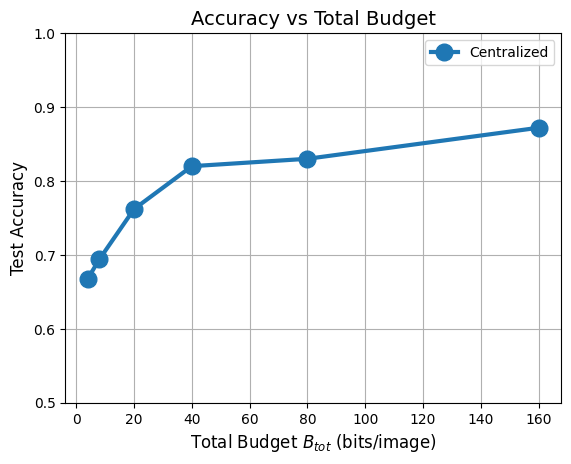

In [7]:
fc = MyFeatureCompression(K=3)
B_tot_list = [4, 8, 20, 40, 80, 160] 
res_central = fc.run_centralized(
    mnist_data['trainX'], mnist_data['trainY'],
    mnist_data['valX'],   mnist_data['valY'],
    mnist_data['testX'],  mnist_data['testY'],
    B_tot_list=B_tot_list,
)
print(res_central)
plot_result_total(result2=res_central, result3_2=None)

## Task 3.1 — Decentralized: fixed per-sensor budget
Uncomment the following once you've implemented `MyFeatureCompression.run_decentralized_per_sensor`.

C:\Users\david\AppData\Roaming\Python\Python313\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\david\AppData\Roaming\Python\Python313\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\david\AppData\Roaming\Python\Python313\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


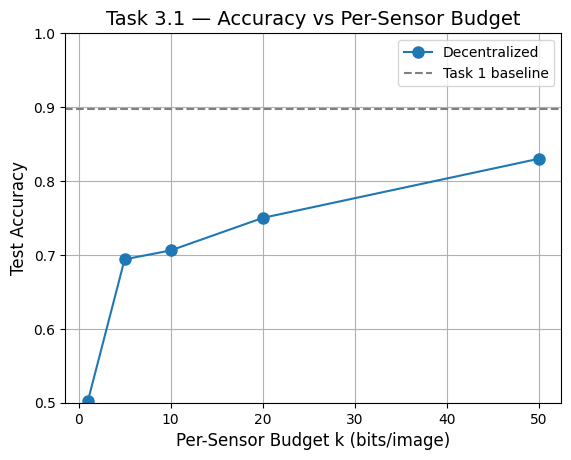

In [8]:
I_train, Xtr_blocks = split_into_quadrants(mnist_data['trainX'])
_,       Xva_blocks = split_into_quadrants(mnist_data['valX'])
_,       Xte_blocks = split_into_quadrants(mnist_data['testX'])

k_list = [1, 5, 10, 20, 50]
res_k = fc.run_decentralized_per_sensor(
    Xtr_blocks, Xva_blocks, Xte_blocks,
    mnist_data['trainY'], mnist_data['valY'], mnist_data['testY'],
    k_list=k_list,
)
res_k['baseline_test_accuracy_task1'] = task1_test_acc
plot_result_per_sensor(result3_1=res_k)

## Task 3.2 — Decentralized: total bit budget
Uncomment the following once you've implemented `MyFeatureCompression.run_decentralized_total`.

In [ ]:
res_B = fc.run_decentralized_total(
    Xtr_blocks, Xva_blocks, Xte_blocks,
    mnist_data['trainY'], mnist_data['valY'], mnist_data['testY'],
    B_tot_list=B_tot_list,
)
plot_result_total(result2=None, result3_2=res_B)

C:\Users\david\AppData\Roaming\Python\Python313\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


KeyboardInterrupt: 

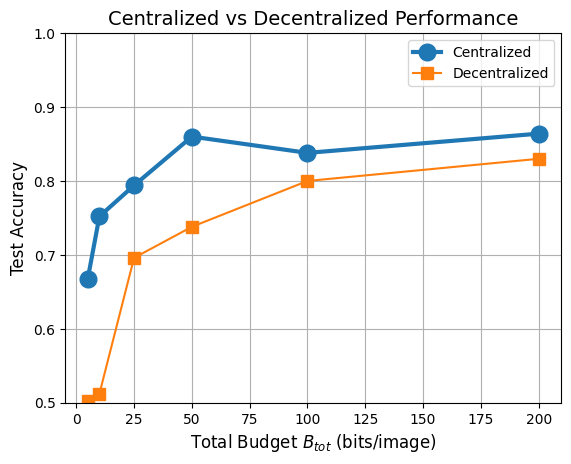

In [ ]:
# overlay centralized vs decentralized
res_compare = {
    'centralized':   res_central,
    'decentralized': res_B,
}
plot_result_centralized_vs_decentralized(result=res_compare)

## Task 3.3 — Minimal bits for target accuracy
Uncomment once you've implemented `MyTargetAllocator` methods.

In [ ]:
# Optimized: run centralized and decentralized budget sweeps once, then lookup minimal B for each alpha
ta = MyTargetAllocator(K=3)
alphas = [0.5, 0.6, 0.7, 0.8, 0.9]  # or choose based on your curves
B_grid = [1, 2, 4, 8, 16, 32, 64, 128, 256]  # example budgets (you can modify)

# --- Run sweeps once (expensive) ---
print("Running centralized sweep over B_grid...")
res_c_sweep = fc.run_centralized(
    mnist_data['trainX'], mnist_data['trainY'],
    mnist_data['valX'],   mnist_data['valY'],
    mnist_data['testX'],  mnist_data['testY'],
    B_tot_list=B_grid
)

print("Running decentralized sweep over B_grid (equal split)...")
res_d_sweep = fc.run_decentralized_total(
    Xtr_blocks, Xva_blocks, Xte_blocks,
    mnist_data['trainY'], mnist_data['valY'], mnist_data['testY'],
    B_tot_list=B_grid
)

# --- Lookup minimal budgets for each alpha ---
cent_min = []
decz_min = []
for a in alphas:
    # Centralized: find smallest B with acc >= a
    Bc = None
    for b, acc in zip(res_c_sweep['B_tot'], res_c_sweep['test_accuracy']):
        if acc >= a:
            Bc = b
            break
    cent_min.append(Bc)

    # Decentralized: find smallest B with acc >= a
    Bd = None
    for b, acc in zip(res_d_sweep['B_tot'], res_d_sweep['test_accuracy']):
        if acc >= a:
            Bd = b
            break
    decz_min.append(Bd)

res_target = {'alphas': alphas, 'centralized_min_bits': cent_min, 'decentralized_min_bits': decz_min}
plot_result_target(result=res_target)


Running centralized sweep over B_grid...


## Mock results (for plotting format only)

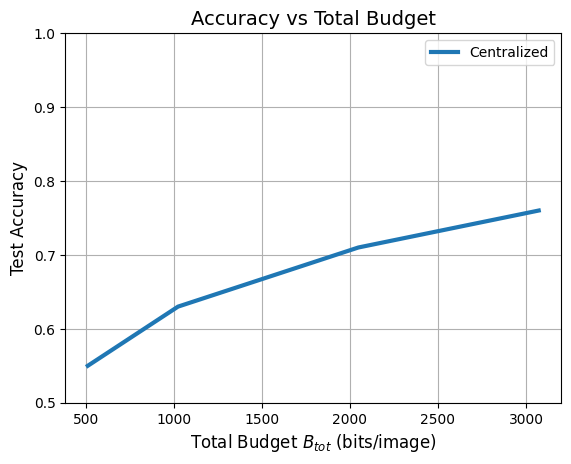

In [ ]:
# --- Task 2 (centralized) mock ---
mock_res_central = {
    'B_tot': [512, 1024, 2048, 3072],
    'test_accuracy': [0.55, 0.63, 0.71, 0.76],
}
plot_result_total(result2=mock_res_central, result3_2=None)

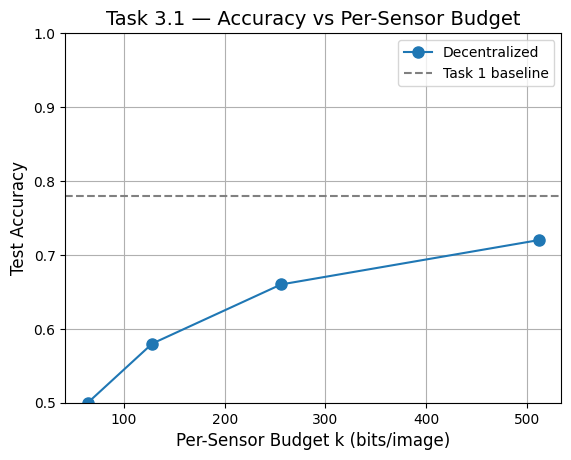

In [ ]:
# --- Task 3.1 (per-sensor) mock ---
mock_res_k = {
    'k': [64, 128, 256, 512],
    'test_accuracy': [0.50, 0.58, 0.66, 0.72],
    'baseline_test_accuracy_task1': 0.78,
    'b_s': [(0,0,0,0),(1,1,1,1),(2,2,2,2),(4,4,4,4)],
}
plot_result_per_sensor(result3_1=mock_res_k)

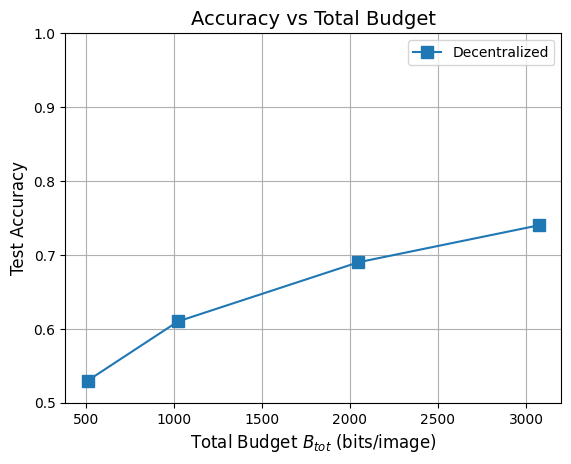

In [ ]:
# --- Task 3.2 (total budget) mock ---
mock_res_B = {
    'B_tot': [512, 1024, 2048, 3072],
    'test_accuracy': [0.53, 0.61, 0.69, 0.74],
    'best_allocation': [(0,2,2,2),(1,1,2,2),(2,2,2,2),(3,3,2,2)],
}
plot_result_total(result2=None, result3_2=mock_res_B)

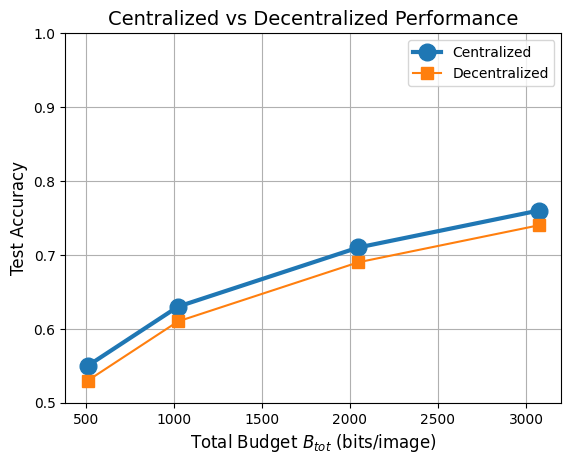

In [ ]:
# --- Centralized vs Decentralized overlay (mock) ---
plot_result_centralized_vs_decentralized(result={
    'centralized': mock_res_central,
    'decentralized': mock_res_B,
})

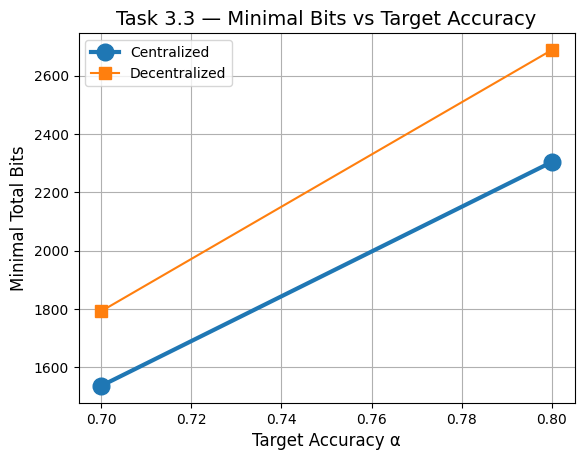

In [ ]:
# --- Task 3.3 (target accuracy) mock ---
mock_res_target = {
    'alphas': [0.7, 0.8, 0.9],
    'centralized_min_bits': [1536, 2304, None],
    'decentralized_min_bits': [1792, 2688, None],
}
plot_result_target(result=mock_res_target)